# Working with NEON AOP Hyperspectral Data in Python Jupyter Notebooks

Hyperspectral remote sensing data is a useful tool for measuring changes to our environment at the Earth’s surface. In this afternoon's lesson's we will explore how to extract information from hyperspectral reflectance data. If you don't have a strong background in hyperspectral imaging, or would like a quick review, we encourage you to watch the following video: 

<a href="http://www.youtube.com/watch?feature=player_embedded&v=3iaFzafWJQE
" target="_blank"><img src="http://img.youtube.com/vi/3iaFzafWJQE/0.jpg" 
alt="IMAGE ALT TEXT HERE" width="400" height="300" border="10" /></a>

## Objectives
This first tutorial will explore how to look inside a NEON hypderspectral hdf5 dataset using Python. We will then develop and practice some tools to manipulate and visualize the spectral data. By the end of this tutorial, you will become familiar with the Jupyter Notebook platform and Python syntax, and learn how to:
1. Import and use Python packages numpy, pandas, matplotlib, h5py, and gdal
2. Use the package h5py to read an hdf5 file and view data attributes
3. Read the data ignore value and scaling factor and apply these values to produce a cleaned reflectance array
4. Extract and plot a single band of reflectance data with different colormaps
5. Plot a histogram of reflectance values
6. Use the Python package gdal to create a properly projected raster from a reflectance array

First let's import the required packages and set our display preferences so that plots are inline and plot warnings are off:

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## Read hdf5 file into Python

In [2]:
f = h5py.File('../data/HOPB/hyperspectral/NIS01_20160818_141517_rdn_ort_atm_nodata.h5','r') 

## Explore HDF5 Files

We can look inside the HDF5 dataest with the ```h5py visititems``` function. The ```list_dataset``` function defined below displays all datasets stored int he hdf5 file and their locations within the hdf5 file:

In [3]:
#list_dataset lists the names of datasets in an hdf5 file
def list_dataset(name,node):
    if isinstance(node, h5py.Dataset):
        print(name)

f.visititems(list_dataset)

HOPB/Reflectance/Metadata/Ancillary_Imagery/Aerosol_Optical_Depth
HOPB/Reflectance/Metadata/Ancillary_Imagery/Aspect
HOPB/Reflectance/Metadata/Ancillary_Imagery/Cast_Shadow
HOPB/Reflectance/Metadata/Ancillary_Imagery/Dark_Dense_Vegetation_Classification
HOPB/Reflectance/Metadata/Ancillary_Imagery/Haze_Cloud_Water_Map
HOPB/Reflectance/Metadata/Ancillary_Imagery/Illumination_Factor
HOPB/Reflectance/Metadata/Ancillary_Imagery/Path_Length
HOPB/Reflectance/Metadata/Ancillary_Imagery/Sky_View_Factor
HOPB/Reflectance/Metadata/Ancillary_Imagery/Slope
HOPB/Reflectance/Metadata/Ancillary_Imagery/Smooth_Surface_Elevation
HOPB/Reflectance/Metadata/Ancillary_Imagery/Visibility_Index_Map
HOPB/Reflectance/Metadata/Ancillary_Imagery/Water_Vapor_Column
HOPB/Reflectance/Metadata/Coordinate_System/Coordinate_System_String
HOPB/Reflectance/Metadata/Coordinate_System/EPSG Code
HOPB/Reflectance/Metadata/Coordinate_System/Map_Info
HOPB/Reflectance/Metadata/Coordinate_System/Proj4
HOPB/Reflectance/Metadata/Fl

We can display the name, shape, and type of each of these datasets using the ```ls_dataset``` function defined below, which is also called with ```visititems```: 

In [4]:
#ls_dataset displays the name, shape, and type of datasets in hdf5 file
def ls_dataset(name,node):
    if isinstance(node, h5py.Dataset):
        print(node)
    
f.visititems(ls_dataset)

<HDF5 dataset "Aerosol_Optical_Depth": shape (6345, 938), type "<i2">
<HDF5 dataset "Aspect": shape (6345, 938), type "<f4">
<HDF5 dataset "Cast_Shadow": shape (6345, 938), type "|u1">
<HDF5 dataset "Dark_Dense_Vegetation_Classification": shape (6345, 938), type "|u1">
<HDF5 dataset "Haze_Cloud_Water_Map": shape (6345, 938), type "|u1">
<HDF5 dataset "Illumination_Factor": shape (6345, 938), type "|u1">
<HDF5 dataset "Path_Length": shape (6345, 938), type "<f4">
<HDF5 dataset "Sky_View_Factor": shape (6345, 938), type "|u1">
<HDF5 dataset "Slope": shape (6345, 938), type "<f4">
<HDF5 dataset "Smooth_Surface_Elevation": shape (6345, 938), type "<f4">
<HDF5 dataset "Visibility_Index_Map": shape (6345, 938), type "|u1">
<HDF5 dataset "Water_Vapor_Column": shape (6345, 938), type "<i2">
<HDF5 dataset "Coordinate_System_String": shape (), type "|O">
<HDF5 dataset "EPSG Code": shape (), type "|O">
<HDF5 dataset "Map_Info": shape (), type "|O">
<HDF5 dataset "Proj4": shape (), type "|O">
<HDF

Now that we see the general structure of the hdf5 file, let's extract the values we are interested in analyzing. Let's start by extracting the reflectance data, which is nested under HOPB/Reflectance/Reflectance_Data.  

In [5]:
hopb_refl = f['HOPB']['Reflectance']
print(hopb_refl)

<HDF5 group "/HOPB/Reflectance" (2 members)>


The two members of the HDF5 group /HOPB/Reflectance are *Metadata* and *Reflectance_Data*. Let's save the reflectance data as the variable hopb_reflArray:

In [6]:
hopb_reflArray = hopb_refl['Reflectance_Data']
print(hopb_reflArray)

<HDF5 dataset "Reflectance_Data": shape (6345, 938, 426), type "<i2">


We can extract the shape as follows: 

In [7]:
refl_shape = hopb_reflArray.shape
print('HOPB Reflectance Data Shape:',refl_shape)

HOPB Reflectance Data Shape: (6345, 938, 426)


This corresponds to (y,x,bands). All NEON hyperspectral data contains 426 wavelength bands ranging from 383.66 - 2511.94 nm. Let's take a look at the wavelength values:

In [8]:
#View wavelength information and values

wavelengths = hopb_refl['Metadata']['Spectral_Data']['Wavelength']
print(wavelengths)
# print(wavelengths.value)
# Display min & max wavelengths
print('min wavelength:',np.amin(wavelengths),'nm')
print('max wavelength:', np.amax(wavelengths),'nm')

#show the band width 
print('band width =',(wavelengths.value[1]-wavelengths.value[0]),'nm')
print('band width =',(wavelengths.value[-1]-wavelengths.value[-2]),'nm')

<HDF5 dataset "Wavelength": shape (426,), type "<f8">
min wavelength: 383.6579 nm
max wavelength: 2511.9379 nm
band width = 5.0077 nm
band width = 5.0078 nm


We can extract spatial information from HOPB/Reflectance/Metadata/Coordinate_System/Map_Info:

In [9]:
hopb_mapInfo = hopb_refl['Metadata']['Coordinate_System']['Map_Info']
print(hopb_mapInfo.value)

b'UTM, 1.000, 1.000, 719408.000, 4710937.000, 1.0000000000e+000, 1.0000000000e+000, 18, North, WGS-84, units=Meters'


**Notes:**
- The 4th and 5th columns of map info signify the coordinates of the map origin, which refers to the upper-left corner of the image  (xMin, yMax). 
- The letter **b** that appears before UTM. This appears because the variable-length string data is stored in **b**inary format when it is written to the hdf5 file. Don't worry about it, as we will conver the numerical data we need to floating point numbers. 

For more information on hdf5 strings, you can refer to: http://docs.h5py.org/en/latest/strings.html

Let's extract relevant information from the Map_Info metadata to determine the spatial extent of this dataset:

In [10]:
#First convert mapInfo to a string, and divide into separate strings using a comma seperator
mapInfo_string = str(hopb_mapInfo.value)
print('Map Info:',mapInfo_string)
mapInfo_split = mapInfo_string.split(",")
# print(mapInfo_split)

Map Info: b'UTM, 1.000, 1.000, 719408.000, 4710937.000, 1.0000000000e+000, 1.0000000000e+000, 18, North, WGS-84, units=Meters'


In [11]:
#Extract the resolution & convert to floating decimal number
res = float(mapInfo_split[5]),float(mapInfo_split[6])
print('Resolution:',res)

#Extract the upper left-hand corner coordinates from mapInfo
xMin = float(mapInfo_split[3]) 
yMax = float(mapInfo_split[4])
#Calculate the xMax and yMin values from the dimensions
#xMax = left corner + (# of columns * resolution)
xMax = xMin + (refl_shape[1]*res[0])
yMin = yMax - (refl_shape[0]*res[1]) 

# print('xMin:',xMin) ; print('xMax:',xMax) 
# print('yMin:',yMin) ; print('yMax:',yMax) 
hopb_ext = (xMin, xMax, yMin, yMax)
print('hopb_ext:',hopb_ext)

#Can also create a dictionary of extent:
h5_ext = {}
h5_ext['xMin'] = xMin
h5_ext['xMax'] = xMax
h5_ext['yMin'] = yMin
h5_ext['yMax'] = yMax
print('h5_ext:',h5_ext)

Resolution: (1.0, 1.0)
hopb_ext: (719408.0, 720346.0, 4704592.0, 4710937.0)
h5_ext: {'yMin': 4704592.0, 'xMin': 719408.0, 'xMax': 720346.0, 'yMax': 4710937.0}


## Extract a single band from the array

In [12]:
b56 = hopb_reflArray[:,:,55].astype(np.float)
print('b56 type:',type(b56))
print('b56 shape:',b56.shape)
print('Band 56 Reflectance:\n',b56)
# plt.hist(b56.flatten())

b56 type: <class 'numpy.ndarray'>
b56 shape: (6345, 938)
Band 56 Reflectance:
 [[-9999. -9999. -9999. ..., -9999. -9999. -9999.]
 [-9999. -9999. -9999. ..., -9999. -9999. -9999.]
 [-9999. -9999. -9999. ..., -9999. -9999. -9999.]
 ..., 
 [-9999. -9999. -9999. ...,    68. -9999. -9999.]
 [-9999. -9999. -9999. ...,    63. -9999. -9999.]
 [-9999. -9999. -9999. ...,    66. -9999. -9999.]]


## Apply the scale factor and data ignore value

In [13]:
#View and apply scale factor and data ignore value
scaleFactor = hopb_reflArray.attrs['Scale_Factor']
noDataValue = hopb_reflArray.attrs['Data_Ignore_Value']
print('Scale Factor:',scaleFactor)
print('Data Ignore Value:',noDataValue)

b56[b56==int(noDataValue)]=np.nan
b56 = b56/scaleFactor
print('Cleaned Band 56 Reflectance:\n',b56)

Scale Factor: 10000.0
Data Ignore Value: -9999.0
Cleaned Band 56 Reflectance:
 [[    nan     nan     nan ...,     nan     nan     nan]
 [    nan     nan     nan ...,     nan     nan     nan]
 [    nan     nan     nan ...,     nan     nan     nan]
 ..., 
 [    nan     nan     nan ...,  0.0068     nan     nan]
 [    nan     nan     nan ...,  0.0063     nan     nan]
 [    nan     nan     nan ...,  0.0066     nan     nan]]


## Plot histogram of reflectance data values

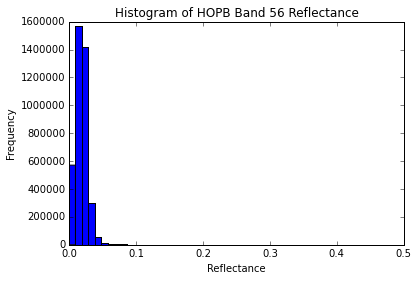

In [14]:
plt.hist(b56[~np.isnan(b56)],50);
plt.title('Histogram of HOPB Band 56 Reflectance')
plt.xlabel('Reflectance'); plt.ylabel('Frequency')

## Plot single reflectance band
Note that the default colormap is jet unless otherwise specified. 

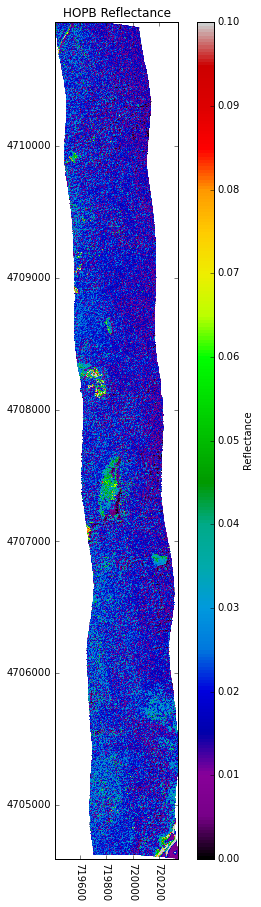

In [15]:
hopb_fig = plt.figure(figsize=(15,15))
ax1 = hopb_fig.add_subplot(1,2,1)
hopb_plot = ax1.imshow(b56,extent=hopb_ext,cmap='spectral',clim=(0,0.1)) 
cbar = plt.colorbar(hopb_plot,aspect=50); cbar.set_label('Reflectance')
plt.title('HOPB Reflectance'); #ax = plt.gca(); 
ax1.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation #
rotatexlabels = plt.setp(ax1.get_xticklabels(),rotation=270) #rotate x tick labels 90 degree

# ax2 = hopb_fig.add_subplot(1,2,2)
# ax2.hist(b56[~np.isnan(b56)],25);
# plt.title('Histogram of HOPB Reflectance')
# plt.xlabel('Reflectance'); plt.ylabel('Frequency')

## Plot a subset of HOPB Data

In [16]:
# %load ../neon_aop_python/calculate_index_extent.py
"""
Created on Thu Jan 19 14:45:14 2017

@author: bhass
"""

#The function calculate_index_extent returns a subset index to slice out data from an H5 file using an input spatial extent.
#Inputs: 
#1. clipExtent: dictionary of the spatial extent of the clip region that you want to use to subset data.
# eg. {'yMin': 4103048, 'xMax': 326235, 'xMin': 326099, 'yMax': 4103192}
#2. h5Extent: the spatial extent of the H5 file. If the extents don't overlap this function won't work.
# eg. 
#Examples: subset_index = calculate_index_extent(clipExtent, h5Extent)

def calc_clip_index(clipExtent, h5Extent, xscale=1, yscale=1):
    #Define a dictionary for the index extent (ind_ext):
    ind_ext = {}
    
    ind_ext['xMin'] = round((clipExtent['xMin']-h5Extent['xMin'])/xscale)
    ind_ext['xMax'] = round((clipExtent['xMax']-h5Extent['xMin'])/xscale)
    ind_ext['yMin'] = round((clipExtent['yMin']-h5Extent['yMin'])/xscale)
    ind_ext['yMax'] = round((clipExtent['yMax']-h5Extent['yMin'])/yscale)

    #print(sub_ext['yMin'])
    #xmin.index = round((clipExtent@xmin- h5Extent@xmin)/xscale)}
    return ind_ext

In [17]:
clipExtent = {}
clipExtent['xMin'] = 719700
clipExtent['xMax'] = 720200
clipExtent['yMin'] = 4708200
clipExtent['yMax'] = 4708800

In [18]:
hopb_subInd = calc_clip_index(clipExtent,h5_ext)
print(hopb_subInd)

{'yMin': 3608, 'xMin': 292, 'xMax': 792, 'yMax': 4208}


In [19]:
hopb_subArray = hopb_reflArray[hopb_subInd['yMin']:hopb_subInd['yMax'],hopb_subInd['xMin']:hopb_subInd['xMax'],:]
hopb_subExt = (clipExtent['xMin'],clipExtent['xMax'],clipExtent['yMin'],clipExtent['yMax'])
print('HOPB Reflectance Subset Shape:',hopb_subArray.shape)

hopb_b56_subset = hopb_subArray[:,:,55].astype(np.float)
hopb_b56_subset[hopb_b56_subset==int(noDataValue)]=np.nan
hopb_b56_subset = hopb_b56_subset/scaleFactor

HOPB Reflectance Subset Shape: (600, 500, 426)


In [20]:
print('min:',np.nanmin(hopb_b56_subset))
print('mean:',round(np.nanmean(hopb_b56_subset),2))
print('max:',round(np.nanmax(hopb_b56_subset),2))

min: 0.0
mean: 0.02
max: 0.15


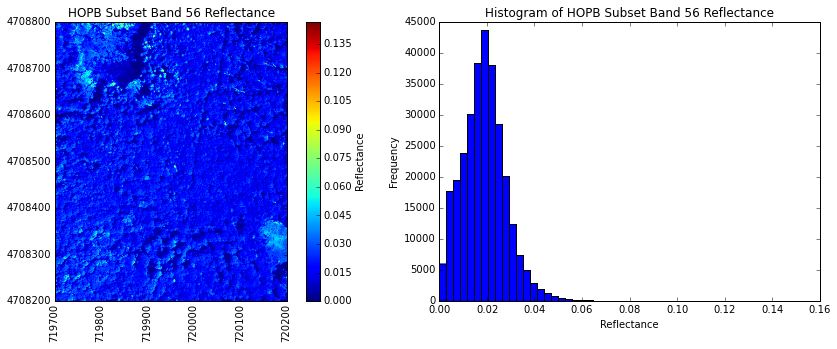

In [21]:
fig = plt.figure(figsize=(15,5))
ax2 = fig.add_subplot(1,2,1)
hopb_subset_plot = plt.imshow(hopb_b56_subset,extent=hopb_subExt) 
cbar = plt.colorbar(hopb_subset_plot); cbar.set_label('Reflectance')
plt.title('HOPB Subset Band 56 Reflectance'); 
ax2.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation #
rotatexlabels = plt.setp(ax2.get_xticklabels(),rotation=90) #rotate x tick labels 90 degree

ax3 = fig.add_subplot(1,2,2)
plt.hist(hopb_b56_subset[~np.isnan(hopb_b56_subset)],50);
plt.title('Histogram of HOPB Subset Band 56 Reflectance')
plt.xlabel('Reflectance'); plt.ylabel('Frequency')

## Test out different plot options to visualize the data:
- Try out some other colormaps with the ```cmap``` option. For a list of colormaps, refer to: http://matplotlib.org/examples/color/colormaps_reference.html. *Note:* You can reverse the order of these colormaps by appending _r to the end (eg. spectral_r).
- Adjust the colorbar limits -- looking at the histogram, most of the reflectance data < 0.08, so you can adjust the maximum `clim` value for more visual contrast.

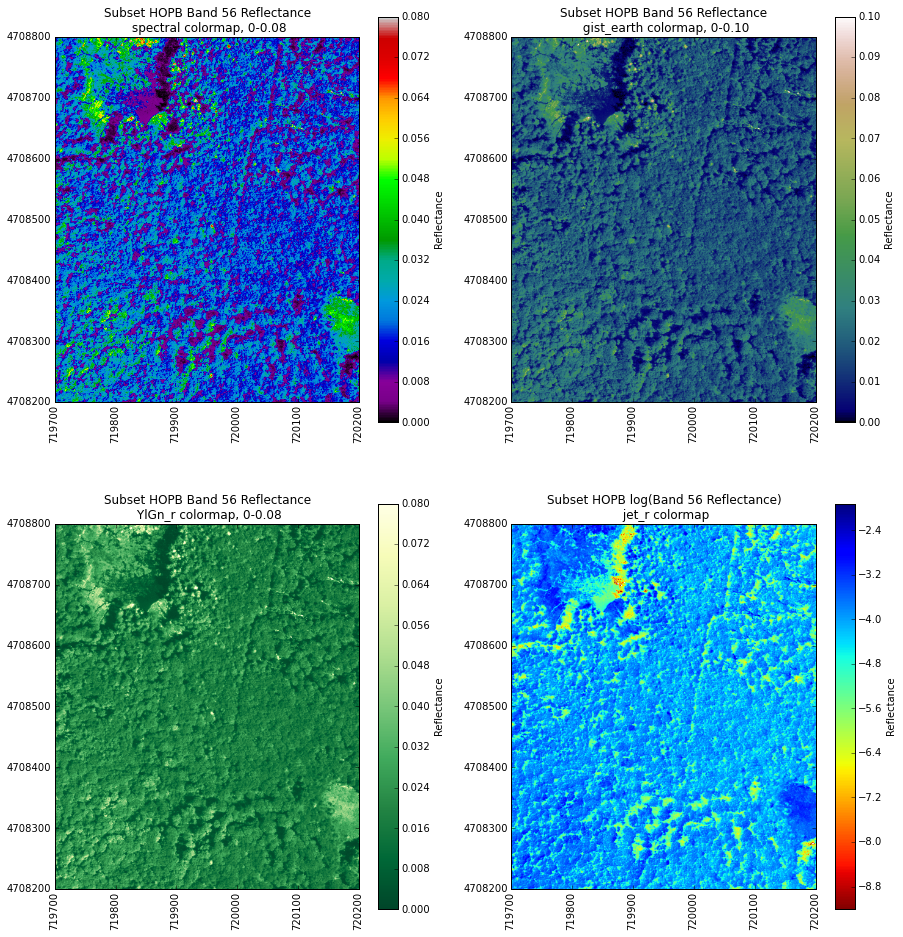

In [22]:
fig = plt.figure(figsize=(15,16))

#spectral Colormap, 0-0.08
ax4 = fig.add_subplot(2,2,1)
hopb_subset_plot = plt.imshow(hopb_b56_subset,extent=hopb_subExt,cmap='spectral',clim=(0,0.08)) 
cbar = plt.colorbar(hopb_subset_plot); cbar.set_label('Reflectance')
plt.title('Subset HOPB Band 56 Reflectance\n spectral colormap, 0-0.08'); 
ax4.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation #
rotatexlabels = plt.setp(ax4.get_xticklabels(),rotation=90) #rotate x tick labels 90 degree

#gist_earth colormap, 0-0.10
ax5 = fig.add_subplot(2,2,2)
hopb_subset_plot = plt.imshow(hopb_b56_subset,extent=hopb_subExt,cmap='gist_earth',clim=(0,0.1)) 
cbar = plt.colorbar(hopb_subset_plot); cbar.set_label('Reflectance')
plt.title('Subset HOPB Band 56 Reflectance\n gist_earth colormap, 0-0.10'); 
ax5.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation #
rotatexlabels = plt.setp(ax5.get_xticklabels(),rotation=90) #rotate x tick labels 90 degree

#YlGn_r colormap, 0-0.08
ax6 = fig.add_subplot(2,2,3)
hopb_subset_plot = plt.imshow(hopb_b56_subset,extent=hopb_subExt,cmap='YlGn_r',clim=(0,0.08)) 
cbar = plt.colorbar(hopb_subset_plot); cbar.set_label('Reflectance')
plt.title('Subset HOPB Band 56 Reflectance\n YlGn_r colormap, 0-0.08'); 
ax6.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation #
rotatexlabels = plt.setp(ax6.get_xticklabels(),rotation=90) #rotate x tick labels 90 degree

#For the last option, take the logarithm of the reflectance data to stretch the values:
hopb_b56_subset_log = np.log(hopb_b56_subset); 
ax7 = fig.add_subplot(2,2,4)
hopb_subset_plot = plt.imshow(hopb_b56_subset_log,extent=hopb_subExt,cmap='jet_r') 
cbar = plt.colorbar(hopb_subset_plot); cbar.set_label('Reflectance')
plt.title('Subset HOPB log(Band 56 Reflectance)\n jet_r colormap'); 
ax7.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation #
rotatexlabels = plt.setp(ax7.get_xticklabels(),rotation=90) #rotate x tick labels 90 degree

## Function to extract reflectance array, wavelength, & select metadata from hdf5 file

In [23]:
import h5py
import numpy as np

def h5refl2array(refl_filename,sitename):

    hdf5_file = h5py.File(refl_filename,'r')
    refl = hdf5_file[sitename]['Reflectance']
    reflArray = refl['Reflectance_Data']
    refl_shape = reflArray.shape
    
    wavelengths = refl['Metadata']['Spectral_Data']['Wavelength']
    
    #Create metadata dictionary 
    metadata = {}
    metadata['shape'] = reflArray.shape
    metadata['mapInfo'] = refl['Metadata']['Coordinate_System']['Map_Info']
    #Extract no data value & set no data value to NaN
    metadata['noDataVal'] = float(reflArray.attrs['Data_Ignore_Value'])
    metadata['scaleFactor'] = float(reflArray.attrs['Scale_Factor'])
    
    metadata['projection'] = refl['Metadata']['Coordinate_System']['Proj4'].value
    metadata['EPSG'] = int(refl['Metadata']['Coordinate_System']['EPSG Code'].value)
    
    mapInfo = refl['Metadata']['Coordinate_System']['Map_Info'].value 
    mapInfo_string = str(mapInfo); #print('Map Info:',mapInfo_string)
    mapInfo_split = mapInfo_string.split(",")
    
    #Extract the resolution & convert to floating decimal number
    metadata['res'] = {}
    metadata['res']['pixelWidth'] = mapInfo_split[5]
    metadata['res']['pixelHeight'] = mapInfo_split[6]

    #Extract the upper left-hand corner coordinates from mapInfo
    xMin = float(mapInfo_split[3]) 
    yMax = float(mapInfo_split[4])
    #Calculate the xMax and yMin values from the dimensions
    #xMax = left corner + (# of columns * resolution)
    xMax = xMin + (refl_shape[1]*float(metadata['res']['pixelWidth']))
    yMin = yMax - (refl_shape[0]*float(metadata['res']['pixelHeight'])) 
    metadata['extent'] = (xMin,xMax,yMin,yMax)
    metadata['ext_dict'] = {}
    metadata['ext_dict']['xMin'] = xMin
    metadata['ext_dict']['xMax'] = xMax
    metadata['ext_dict']['yMin'] = yMin
    metadata['ext_dict']['yMax'] = yMax

    return reflArray, metadata, wavelengths

In [24]:
hopbRefl, hopbRefl_md, wavelengths = h5refl2array('../data/HOPB/hyperspectral/NIS01_20160818_141517_rdn_ort_atm_nodata.h5','HOPB')

In [25]:
print(hopbRefl.shape)
print(hopbRefl.dtype)
print(hopbRefl[:,:,55].astype(float))

for item in sorted(hopbRefl_md):
    print(item + ':',hopbRefl_md[item])

(6345, 938, 426)
int16
[[-9999. -9999. -9999. ..., -9999. -9999. -9999.]
 [-9999. -9999. -9999. ..., -9999. -9999. -9999.]
 [-9999. -9999. -9999. ..., -9999. -9999. -9999.]
 ..., 
 [-9999. -9999. -9999. ...,    68. -9999. -9999.]
 [-9999. -9999. -9999. ...,    63. -9999. -9999.]
 [-9999. -9999. -9999. ...,    66. -9999. -9999.]]
EPSG: 32618
ext_dict: {'yMin': 4704592.0, 'xMin': 719408.0, 'xMax': 720346.0, 'yMax': 4710937.0}
extent: (719408.0, 720346.0, 4704592.0, 4710937.0)
mapInfo: <HDF5 dataset "Map_Info": shape (), type "|O">
noDataVal: -9999.0
projection: b'+proj=UTM +zone= 18 +ellps= WGS-84 +datum= WGS-84 +units= units=Meters +no_defs'
res: {'pixelWidth': ' 1.0000000000e+000', 'pixelHeight': ' 1.0000000000e+000'}
scaleFactor: 10000.0
shape: (6345, 938, 426)


In [26]:
import copy

def extract_clean_band(reflArray,reflArray_metadata,band_ind):
    bandArray = reflArray[:,:,band_ind-1].astype(np.float)
    bandCleaned = copy.copy(bandArray)
    bandCleaned[bandCleaned==int(reflArray_metadata['noDataVal'])]=np.nan
    bandCleaned = bandCleaned/reflArray_metadata['scaleFactor']
    return bandArray, bandCleaned

In [27]:
b56, b56_clean = extract_clean_band(hopbRefl,hopbRefl_md,56)
print('Band 56:\n',b56)
print('Band 56 Cleaned:\n',b56_clean)

Band 56:
 [[-9999. -9999. -9999. ..., -9999. -9999. -9999.]
 [-9999. -9999. -9999. ..., -9999. -9999. -9999.]
 [-9999. -9999. -9999. ..., -9999. -9999. -9999.]
 ..., 
 [-9999. -9999. -9999. ...,    68. -9999. -9999.]
 [-9999. -9999. -9999. ...,    63. -9999. -9999.]
 [-9999. -9999. -9999. ...,    66. -9999. -9999.]]
Band 56 Cleaned:
 [[    nan     nan     nan ...,     nan     nan     nan]
 [    nan     nan     nan ...,     nan     nan     nan]
 [    nan     nan     nan ...,     nan     nan     nan]
 ..., 
 [    nan     nan     nan ...,  0.0068     nan     nan]
 [    nan     nan     nan ...,  0.0063     nan     nan]
 [    nan     nan     nan ...,  0.0066     nan     nan]]


In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_band_array(band_array,refl_extent,size=(6,6),title='',cmap_title='',colormap='spectral'):
    fig = plt.figure(figsize=size)
    plot = plt.imshow(band_array,extent=refl_extent); 
    cbar = plt.colorbar(plot,aspect=40); plt.set_cmap(colormap); 
    cbar.set_label(cmap_title,rotation=90,labelpad=20)
    plt.title(title); ax = plt.gca(); 
    ax.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation #
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees

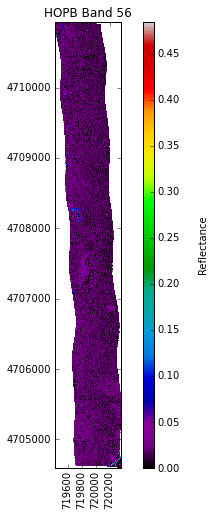

In [29]:
plot_band_array(b56_clean,hopbRefl_md['extent'],size=(8,8),title='HOPB Band 56',cmap_title='Reflectance')

In [30]:
import gdal, osr
def array2raster(newRaster,reflBandArray,reflArray_metadata,epsg): 
    cols = reflBandArray.shape[1]
    rows = reflBandArray.shape[0]
    pixelWidth = float(reflArray_metadata['res']['pixelWidth'])
    pixelHeight = -float(reflArray_metadata['res']['pixelHeight'])
    originX = reflArray_metadata['ext_dict']['xMin']
    originY = reflArray_metadata['ext_dict']['yMax']
    
    driver = gdal.GetDriverByName('GTiff')
    outRaster = driver.Create('hopb_b56.tif', cols, rows, 1, gdal.GDT_Byte)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    outband = outRaster.GetRasterBand(1)
    outband.WriteArray(reflBandArray)
    outRasterSRS = osr.SpatialReference()
    outRasterSRS.ImportFromEPSG(epsg) #4326 = WGS84
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()

In [31]:
array2raster('hopb_b56.tif',b56,hopbRefl_md,hopbRefl_md['EPSG'])

hopb_b56.png


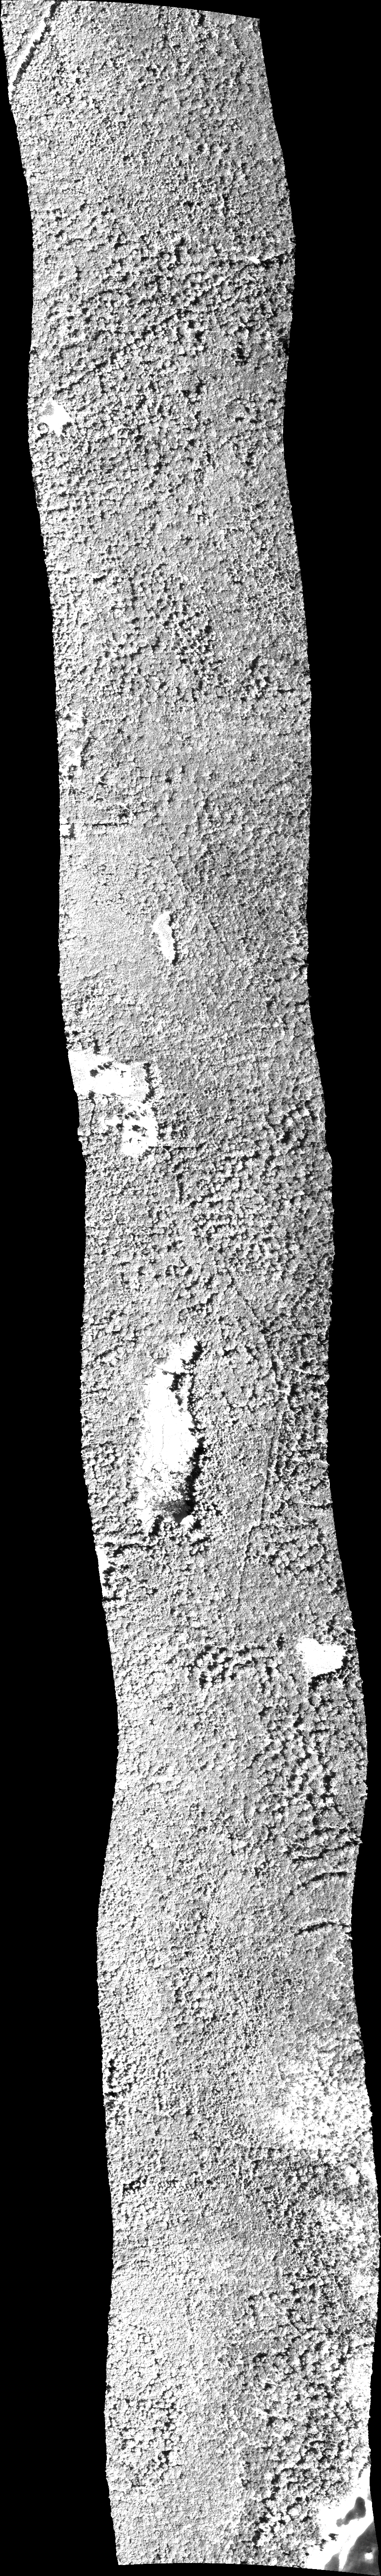

In [32]:
#Display the geotif raster
#Note this display will not reflect the spatial orientation or information 
from PIL import Image
img = Image.open('hopb_b56.tif')
img.save('hopb_b56.png')

import IPython.display 
print('hopb_b56.png')
IPython.display.Image(filename='hopb_b56.png',width=90,height=90)